In [43]:
# Packages 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt

# Data Cleaning
import regex as re 
from skimpy import clean_columns

# Additional Plots 
from plotnine import ggplot, geom_point, aes, geom_smooth, facet_wrap, labs, theme_bw,scale_fill_manual, scale_fill_discrete
# from plotnine.data import mtcars


# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from scipy.stats import zscore


# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
# !pip install xgboost --user
import xgboost as xgb


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# To tune the model
from sklearn.model_selection import KFold, GridSearchCV, train_test_split


# Metrics to evaluate the model (CART Models)
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer

import random # Random to set a seed


# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score, recall_score


In [44]:
# Functions 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True,  fmt = '.6f', 
                xticklabels = ['Not Defaulted', 'Defaulted'], 
                yticklabels = ['Not Defaulted', 'Defaulted'])
    
    plt.ylabel('Actual',fontweight='bold')
    
    plt.xlabel('Predicted', fontweight='bold')
    
    plt.show()
    

    
def scatter_plot(x_val,y_val):
    plot = ggplot(df_copy, aes(str(x_val), str(y_val), color='factor(BAD)')) # x-axis y-axis
    print(plot + geom_point() + theme_bw() +  facet_wrap('~BAD', labeller = {"0":'Loan Repaid',"1":'Defaulter'}) \
               + labs(x = x_val, y = y_val, title = x_val + " VS. " + y_val)
               )
    
    
    
def AUC_ROC_Graph(model,model_name,data, thres_hold=0.5):
    y_pred_proba = model.predict_proba(data)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test,y_pred_proba)
    
    #create ROC curve
    plt.figure(figsize = (8, 5))
    plt.plot(fpr,tpr,label="AUC = "+ str(round(auc,8)))
    plt.title(str(model_name) +" ROC-AUC Graph", fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.legend(loc=4)
    plt.show()
    
def AUC_score(model,data):    
    y_pred_proba = model.predict_proba(data)[::,1]
    auc = roc_auc_score(y_test, y_pred_proba) 

    return auc 


def get_recall_score(model,flag,X_train,X_test):
    '''
    model : classifier to predict values of X

    '''
    a = [] # defining an empty list to store train and test results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    a.append(train_recall) # adding train recall to list 
    a.append(test_recall) # adding test recall to list
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
    
    return a # returning the list with train and test scores

##  Function to calculate precision score
def get_precision_score(model,flag,X_train,X_test):
    '''
    model : classifier to predict values of X

    '''
    b = []  # defining an empty list to store train and test results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    b.append(train_precision) # adding train precision to list
    b.append(test_precision) # adding test precision to list
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

    return b # returning the list with train and test scores


##  Function to calculate accuracy score
def get_accuracy_score(model,flag,X_train,X_test):
    '''
    model : classifier to predict values of X

    '''
    c = [] # defining an empty list to store train and test results
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    c.append(train_acc) # adding train accuracy to list
    c.append(test_acc) # adding test accuracy to list
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
    
    return c # returning the list with train and test scores
       

In [45]:
# Reading In the Data
train_df = 'training_data.csv'
test_df = 'testing_data.csv'



train = pd.read_csv(train_df)
test = pd.read_csv(test_df)

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   ID                         105000 non-null  int64 
 1   Date_Of_Disbursement       104765 non-null  object
 2   Business                   104985 non-null  object
 3   Jobs_Reatained             105000 non-null  int64 
 4   Jobs_Created               105000 non-null  int64 
 5   Year_Of_Commitment         105000 non-null  object
 6   Guaranteed_Approved _Loan  105000 non-null  object
 7   Borrower_Name              104997 non-null  object
 8   Low_Documentation_Loan     104633 non-null  object
 9   Demography                 105000 non-null  object
 10  State_Of_Bank              105000 non-null  object
 11  ChargedOff_Amount          105000 non-null  object
 12  Borrower_City              105000 non-null  object
 13  Borrower_State             105000 non-null  

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         45000 non-null  int64 
 1   Date_Of_Disbursement       44892 non-null  object
 2   Business                   44994 non-null  object
 3   Jobs_Reatained             45000 non-null  int64 
 4   Jobs_Created               45000 non-null  int64 
 5   Year_Of_Commitment         45000 non-null  object
 6   Guaranteed_Approved _Loan  45000 non-null  object
 7   Borrower_Name              44998 non-null  object
 8   Low_Documentation_Loan     44867 non-null  object
 9   Demography                 45000 non-null  object
 10  State_Of_Bank              45000 non-null  object
 11  ChargedOff_Amount          45000 non-null  object
 12  Borrower_City              45000 non-null  object
 13  Borrower_State             44951 non-null  object
 14  Gross_

# Data Wrangling / Exploratory Data Analysis

In [48]:
combine_df = pd.concat([train, test], axis=0)
combine_df = clean_columns(combine_df, case = 'pascal') # Cleaning the spacing within the columns
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 44999
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      150000 non-null  int64  
 1   DateOfDisbursement      149657 non-null  object 
 2   Business                149979 non-null  object 
 3   JobsReatained           150000 non-null  int64  
 4   JobsCreated             150000 non-null  int64  
 5   YearOfCommitment        150000 non-null  object 
 6   GuaranteedApprovedLoan  150000 non-null  object 
 7   BorrowerName            149995 non-null  object 
 8   LowDocumentationLoan    149500 non-null  object 
 9   Demography              150000 non-null  object 
 10  StateOfBank             150000 non-null  object 
 11  ChargedOffAmount        150000 non-null  object 
 12  BorrowerCity            150000 non-null  object 
 13  BorrowerState           149951 non-null  object 
 14  GrossAmountBalance   

In [49]:
combine_df.head(3)

,Id,DateOfDisbursement,Business,JobsReatained,JobsCreated,YearOfCommitment,GuaranteedApprovedLoan,BorrowerName,LowDocumentationLoan,Demography,...,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,CommitmentDate,PrimaryLoanDigit,CodeFranchise,NameOfBank,RevolvingCreditLine,Default
0,0,31-Jul-91,Existing,0,0,1991,Rs.33121600.0,STANDARD PARTS CORPORATION,No,Undefined,...,0,Rs.40640000.0,Rs.40640000.0,126,2-Apr-91,4419763001,1,Axis Bank Ltd.,No,0.0
1,1,30-Apr-06,New,0,6,2006,Rs.32735520.0,FRANK & KERI AMESTOY,No,Urban,...,451120,Rs.43647360.0,Rs.43647360.0,123,10-Apr-06,1709796003,1,Bandhan Bank Ltd.,0,1.0
2,2,30-Jun-04,Existing,4,0,2004,Rs.1422400.0,TELECOMMQC L L C,No,Urban,...,541618,Rs.2844800.0,Rs.5961400.32,90,25-May-04,7464754008,1,CSB Bank Limited,Yes,0.0


In [50]:
print('Numeric Cols NAs')
combine_df.loc[:,(combine_df.dtypes == 'int') | (combine_df.dtypes == 'float')].isna().sum()

Numeric Cols NAs


Id                        0
JobsReatained             0
JobsCreated               0
CountEmployees            0
ClassificationCode        0
LoanTerm                  0
PrimaryLoanDigit          0
CodeFranchise             0
Default               45000
dtype: int64

In [51]:
print('Object Cols NAs')
combine_df.loc[:,(combine_df.dtypes == 'object')].isna().sum()

Object Cols NAs


DateOfDisbursement          343
Business                     21
YearOfCommitment              0
GuaranteedApprovedLoan        0
BorrowerName                  5
LowDocumentationLoan        500
Demography                    0
StateOfBank                   0
ChargedOffAmount              0
BorrowerCity                  0
BorrowerState                49
GrossAmountBalance            0
LoanApprovedGross             0
GrossAmountDisbursed          0
CommitmentDate                0
NameOfBank                    0
RevolvingCreditLine       14316
dtype: int64

In [52]:
# Objects --> Numeric 

num_col = ["ChargedOffAmount", "GuaranteedApprovedLoan","GrossAmountBalance", "LoanApprovedGross", 
           "GrossAmountDisbursed"]

for col in num_col:
    print('Pre-Transformation')
    print(combine_df[col].head(),'\n')
    
    combine_df[col].replace('(Rs.)','',regex=True, inplace = True) # Removing letters from  numeric cols
    combine_df[col] = pd.to_numeric(combine_df[col])
    
    print('Post-Transformation')
    print(combine_df[col].head(),'\n')
#     break
    

Pre-Transformation
0            Rs.0.0
1    Rs.38283367.68
2            Rs.0.0
3            Rs.0.0
4    Rs.22862519.68
Name: ChargedOffAmount, dtype: object 

Post-Transformation
0           0.00
1    38283367.68
2           0.00
3           0.00
4    22862519.68
Name: ChargedOffAmount, dtype: float64 

Pre-Transformation
0    Rs.33121600.0
1    Rs.32735520.0
2     Rs.1422400.0
3     Rs.2032000.0
4    Rs.22981920.0
Name: GuaranteedApprovedLoan, dtype: object 

Post-Transformation
0    33121600.0
1    32735520.0
2     1422400.0
3     2032000.0
4    22981920.0
Name: GuaranteedApprovedLoan, dtype: float64 

Pre-Transformation
0    Rs.0.0
1    Rs.0.0
2    Rs.0.0
3    Rs.0.0
4    Rs.0.0
Name: GrossAmountBalance, dtype: object 

Post-Transformation
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: GrossAmountBalance, dtype: float64 

Pre-Transformation
0    Rs.40640000.0
1    Rs.43647360.0
2     Rs.2844800.0
3     Rs.4064000.0
4    Rs.30642560.0
Name: LoanApprovedGross, dtype: object 

Post

**Notes:**   
    - Cols to remove:   
       - Time Series-ish Data:    
          - DateOfDisbursement appears to be a date time. I am not going to need this column for my analysis.    
          - YearOfCommitment  
          - CommitmentDate   
       -  BorrowerCity --> redundant      
       - Too many unique values. Currently, no way to reduce the factors into meaningful statistcal values:
          - BorrowerName 
          - NameOfBank 
          - StateOfBank  
          - CodeFranchise 
   - Turn into Numeric data type      
      - ChargedOffAmount    
      - GuaranteedApprovedLoan
      - GrossAmountBalance
      - LoanApprovedGross
      - GrossAmountDisbursed
   - Shrink number of levels in col:          
     - BorrowerState 
        - India
        - Northern_Region
           - Chandigarh
           - Delhi
           - Haryana
           - Himachal Pradesh
           - Jammu and Kashmir
           - Punjab
           - Rajasthan
           - Ajmer
        - NORTH_EASTERN_REGION
           - Arunachal Pradesh
           - Assam
           - Manipur
           - Meghalaya
           - Mizoram
           - Nagaland
           - Tripura
           - Uttarakhand
           - Farrukhabad
        - EASTERN_REGION
           - Andaman and Nicobar Islands
           - Bihar
           - Jharkhand
           - Orissa
           - Sikkim
           - West Bengal
           - Odisha
        - CENTRAL_REGION
           - Chhattisgarh
           - Central India
           - Uttar Pradesh
           - Rampur
           - Agra
           - Hardoi
           - Uttaranchal
           - Bulandshahr
           - Madhya Pradesh
           - Hardoi
           - Bulandshahr
        - WESTERN_REGION
           - Dadra and Nagar Haveli 
           - Daman and Diu
           - Goa
           - Gujarat
           - Maharashtra
        - SOUTHERN_REGION
           - Andhra Pradesh
           - Karnataka
           - Kerala
           - Lakshadweep
           - Pondicherry
           - Puducherry
           - Tamil Nadu
           - Trilinga
           - Karnatka
           - Telangana
   - LowDocumentationLoan - What is going on with the additional levels (0,S,C,A,R)      

In [53]:
city_dict = {
'NORTHERN_REGION': ["Chandigarh", "Delhi", "Haryana", "Himachal Pradesh", 
                   "Jammu and Kashmir", "Punjab", "Rajasthan" ,' Ajmer'],

'NORTH_EASTERN_REGION': ['Arunachal Pradesh', 'Assam', 'Manipur', 'Meghalaya',
'Mizoram', 'Nagaland', 'Tripura', 'Uttarakhand', ' Farrukhabad'],

'EASTERN_REGION': ["Andaman and Nicobar Islands", "Bihar", 'Jharkhand', 'Orissa',
'Sikkim', 'West Bengal', 'Odisha'],

'CENTRAL_REGION': ['Chhattisgarh', 'Central India', 'Uttar Pradesh', ' Rampur',
' Agra', ' Hardoi', 'Uttaranchal', ' Bulandshahr','Madhya Pradesh','Hardoi','Bulandshahr'],

'WESTERN_REGION': ['Dadra and Nagar Haveli', 'Daman and Diu', 'Goa', 'Gujarat', 'Maharashtra'],

'SOUTHERN_REGION': ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Lakshadweep',
'Pondicherry', 'Puducherry', 'Tamil Nadu', 'Trilinga', 'Karnatka','Telangana']
}

In [54]:
# Adjusting the levels of the 'BorrowerState' perdictor. There should be eight levels. 
for region, cities in city_dict.items():
#     print(region)
    for city in cities:
#         print(region,city,'\n')
        combine_df.loc[combine_df['BorrowerState']== city,'BorrowerState'] = region

#     break

combine_df.loc[combine_df['BorrowerState'] == ' India','BorrowerState'] = 'INDIA'

In [55]:
# The system would not recognize 0.0. It kept putting 0. [Still a float. I need an integer]

combine_df.loc[combine_df['Default'] == 0.0,'Default'] = '0'
combine_df.loc[combine_df['Default'] == 1.0,'Default'] = '1'


combine_df.loc[combine_df['Default'] == '0','Default'] = 0
combine_df.loc[combine_df['Default'] == '1','Default'] = 1

combine_df['Default'].unique()

array([0, 1, nan], dtype=object)

### Dropping Columns

In [56]:
# Dropping some columns
try:
    combine_df = combine_df.drop(['BorrowerCity','BorrowerName','DateOfDisbursement','StateOfBank',
                              'YearOfCommitment','CommitmentDate','NameOfBank','CodeFranchise'], axis=1)
except:
    pass

print(combine_df['BorrowerState'].unique()) # Verifying all of the cities were accounted for.
combine_df.head()

['WESTERN_REGION' 'NORTHERN_REGION' 'SOUTHERN_REGION' 'EASTERN_REGION'
 'CENTRAL_REGION' 'NORTH_EASTERN_REGION' 'INDIA' nan]


,Id,Business,JobsReatained,JobsCreated,GuaranteedApprovedLoan,LowDocumentationLoan,Demography,ChargedOffAmount,BorrowerState,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit,RevolvingCreditLine,Default
0,0,Existing,0,0,33121600.0,No,Undefined,0.00,WESTERN_REGION,0.0,38,0,40640000.0,40640000.00,126,4419763001,No,0
1,1,New,0,6,32735520.0,No,Urban,38283367.68,NORTHERN_REGION,0.0,6,451120,43647360.0,43647360.00,123,1709796003,0,1
2,2,Existing,4,0,1422400.0,No,Urban,0.00,SOUTHERN_REGION,0.0,4,541618,2844800.0,5961400.32,90,7464754008,Yes,0
3,3,New,9,1,2032000.0,No,Urban,0.00,WESTERN_REGION,0.0,7,811112,4064000.0,4064000.00,126,1588745006,Yes,0
4,4,Existing,4,0,22981920.0,No,Urban,22862519.68,SOUTHERN_REGION,0.0,4,722211,30642560.0,30642560.00,104,8037734002,0,1


In [57]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 44999
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      150000 non-null  int64  
 1   Business                149979 non-null  object 
 2   JobsReatained           150000 non-null  int64  
 3   JobsCreated             150000 non-null  int64  
 4   GuaranteedApprovedLoan  150000 non-null  float64
 5   LowDocumentationLoan    149500 non-null  object 
 6   Demography              150000 non-null  object 
 7   ChargedOffAmount        150000 non-null  float64
 8   BorrowerState           149951 non-null  object 
 9   GrossAmountBalance      150000 non-null  float64
 10  CountEmployees          150000 non-null  int64  
 11  ClassificationCode      150000 non-null  int64  
 12  LoanApprovedGross       150000 non-null  float64
 13  GrossAmountDisbursed    150000 non-null  float64
 14  LoanTerm             

### Treat Null Values 

In [58]:
## Categorical Values with NAs and other...

# Pulling the numerical columns that need filling

obj_cols_NAs = combine_df.loc[:,combine_df.dtypes == object].isna().sum()
obj_cols_NAs = obj_cols_NAs[obj_cols_NAs > 0].index # Grabbing the numeric colums that have NAs 
obj_cols_NAs = [na_col for na_col in obj_cols_NAs]


for col in obj_cols_NAs:
    print('Column Name: %s' % col)
    print(round((combine_df[col].value_counts()/combine_df.shape[0])*100,3))
    print('Columns type: %s' %combine_df[col].dtypes)
    print('NA percentage: %.2f  \n' % sum(combine_df[col].isna()/combine_df.shape[0]*100))

Column Name: Business
Existing    71.435
New         28.445
0            0.106
Name: Business, dtype: float64
Columns type: object
NA percentage: 0.01  

Column Name: LowDocumentationLoan
No     87.741
Yes    11.528
0       0.158
S       0.092
C       0.080
A       0.062
R       0.006
Name: LowDocumentationLoan, dtype: float64
Columns type: object
NA percentage: 0.33  

Column Name: BorrowerState
SOUTHERN_REGION         28.709
CENTRAL_REGION          19.577
WESTERN_REGION          17.965
EASTERN_REGION          15.141
NORTHERN_REGION         13.827
NORTH_EASTERN_REGION     4.704
INDIA                    0.045
Name: BorrowerState, dtype: float64
Columns type: object
NA percentage: 0.03  

Column Name: RevolvingCreditLine
No     45.742
Yes    23.551
0      19.741
T       1.413
R       0.003
`       0.001
1       0.001
2       0.001
4       0.001
.       0.001
C       0.001
Name: RevolvingCreditLine, dtype: float64
Columns type: object
NA percentage: 9.54  

Column Name: Default
0    50.5

In [59]:
na_cols = ['Business', 'LowDocumentationLoan', 'BorrowerState', 'RevolvingCreditLine']
for col in na_cols:
#     print(col)
    combine_df.loc[combine_df[col].isna(),col] = combine_df[col].mode()[0]

In [60]:

# combine_df.loc[(combine_df['Business'] != 'Existing') & (combine_df['Business'] != 'New'),
#                'Business'] = combine_df['Business'].mode()[0]

# combine_df.loc[(combine_df['LowDocumentationLoan'] != 'No') & (combine_df['LowDocumentationLoan'] != 'Yes'),
#                'LowDocumentationLoan'] = combine_df['LowDocumentationLoan'].mode()[0]

# combine_df.loc[combine_df['BorrowerState'].isna(),'BorrowerState'] = combine_df['BorrowerState'].mode()[0]

# combine_df.loc[(combine_df['RevolvingCreditLine'] != 'No') & (combine_df['RevolvingCreditLine'] != 'Yes'),
#                'RevolvingCreditLine'] = combine_df['RevolvingCreditLine'].mode()[0]

In [61]:
combine_df['Business'].unique()
combine_df['LowDocumentationLoan'].unique()
combine_df['BorrowerState'].unique()
combine_df['RevolvingCreditLine'].unique()



array(['No', '0', 'Yes', 'T', 'R', '`', '2', '4', '.', '1', 'C'],
      dtype=object)

In [62]:
combine_df.isna().sum()

Id                            0
Business                      0
JobsReatained                 0
JobsCreated                   0
GuaranteedApprovedLoan        0
LowDocumentationLoan          0
Demography                    0
ChargedOffAmount              0
BorrowerState                 0
GrossAmountBalance            0
CountEmployees                0
ClassificationCode            0
LoanApprovedGross             0
GrossAmountDisbursed          0
LoanTerm                      0
PrimaryLoanDigit              0
RevolvingCreditLine           0
Default                   45000
dtype: int64

**Note:**
    - I don't need to add any values for default. Due to the nature of this hackathon, the original test data set did not have a 'Default' column, and since I joined the train and test data, I amassed 4500 NAs for default. Which is the length of the test dataset.

### Changing Data Types

In [63]:
object_columns = combine_df.loc[:,(combine_df.dtypes == object)].columns
combine_df[object_columns].head()

,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine,Default
0,Existing,No,Undefined,WESTERN_REGION,No,0
1,New,No,Urban,NORTHERN_REGION,0,1
2,Existing,No,Urban,SOUTHERN_REGION,Yes,0
3,New,No,Urban,WESTERN_REGION,Yes,0
4,Existing,No,Urban,SOUTHERN_REGION,0,1


In [64]:
'''Changing the object columns into categories
Checking the percentage breakdown of each factor per column'''
for col in object_columns:
    print('Column Name: %s' % col)
    print(round((combine_df[col].value_counts()/combine_df.shape[0])*100,3))
#     print(train[col].astype("category").value_counts(), '\n')
    print('Columns type: %s' %combine_df[col].dtypes)
    print('NA percentage: %.2f  \n' % sum(combine_df[col].isna()/combine_df.shape[0]*100))
    combine_df[col] = combine_df[col].astype("category")

Column Name: Business
Existing    71.449
New         28.445
0            0.106
Name: Business, dtype: float64
Columns type: object
NA percentage: 0.00  

Column Name: LowDocumentationLoan
No     88.074
Yes    11.528
0       0.158
S       0.092
C       0.080
A       0.062
R       0.006
Name: LowDocumentationLoan, dtype: float64
Columns type: object
NA percentage: 0.00  

Column Name: Demography
Urban        54.789
Undefined    33.413
Rural        11.798
Name: Demography, dtype: float64
Columns type: object
NA percentage: 0.00  

Column Name: BorrowerState
SOUTHERN_REGION         28.741
CENTRAL_REGION          19.577
WESTERN_REGION          17.965
EASTERN_REGION          15.141
NORTHERN_REGION         13.827
NORTH_EASTERN_REGION     4.704
INDIA                    0.045
Name: BorrowerState, dtype: float64
Columns type: object
NA percentage: 0.00  

Column Name: RevolvingCreditLine
No     55.286
Yes    23.551
0      19.741
T       1.413
R       0.003
`       0.001
1       0.001
2       0.0

In [65]:
# Changing the response
combine_df['Default'] = combine_df['Default'].astype('category')

In [66]:
combine_df.info() # Everything is in its proper type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 44999
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Id                      150000 non-null  int64   
 1   Business                150000 non-null  category
 2   JobsReatained           150000 non-null  int64   
 3   JobsCreated             150000 non-null  int64   
 4   GuaranteedApprovedLoan  150000 non-null  float64 
 5   LowDocumentationLoan    150000 non-null  category
 6   Demography              150000 non-null  category
 7   ChargedOffAmount        150000 non-null  float64 
 8   BorrowerState           150000 non-null  category
 9   GrossAmountBalance      150000 non-null  float64 
 10  CountEmployees          150000 non-null  int64   
 11  ClassificationCode      150000 non-null  int64   
 12  LoanApprovedGross       150000 non-null  float64 
 13  GrossAmountDisbursed    150000 non-null  float64 
 14  LoanT

### Scale Numeric Data

In [67]:
combine_df_copy = combine_df.copy()

scaler = RobustScaler()


'''Grabbing everything with the exception of Id columns. 
I cannot drop this columns because I need it for the hackathon submission.'''
num_cols_to_scale = combine_df.loc[:,(combine_df.dtypes == 'int') | (combine_df.dtypes == 'float')].columns[1:] 
numerical_data = combine_df[num_cols_to_scale]
scaled = scaler.fit_transform(numerical_data)

# Put into dataframe 
data_scaled = pd.DataFrame(scaled, columns = num_cols_to_scale)
print('Numeric Scaled Data',data_scaled.shape)
data_scaled.head(6)



Numeric Scaled Data (150000, 11)


,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit
0,-0.25,0.0,2.500000,0.000000,0.0,4.857143,-1.373083,2.366197,2.194861,0.000000,0.071863
1,-0.25,6.0,2.466596,61.036835,0.0,0.285714,0.012315,2.574648,2.395948,-0.033333,-0.563248
2,0.75,0.0,-0.242616,0.000000,0.0,0.000000,0.290236,-0.253521,-0.123921,-0.400000,0.785490
3,2.00,1.0,-0.189873,0.000000,0.0,0.428571,1.117856,-0.169014,-0.250791,0.000000,-0.591617
4,0.75,0.0,1.622714,36.450708,0.0,0.000000,0.844840,1.673239,1.526383,-0.244444,0.919774
5,0.50,0.0,-0.348101,0.000000,0.0,-0.142857,0.021804,-0.422535,-0.495356,0.000000,0.195917


In [68]:
cat_df = combine_df.loc[:,(combine_df.dtypes == 'category')]
print('Categorical Scaled Data',cat_df.shape)

cat_df.head()


Categorical Scaled Data (150000, 6)


,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine,Default
0,Existing,No,Undefined,WESTERN_REGION,No,0
1,New,No,Urban,NORTHERN_REGION,0,1
2,Existing,No,Urban,SOUTHERN_REGION,Yes,0
3,New,No,Urban,WESTERN_REGION,Yes,0
4,Existing,No,Urban,SOUTHERN_REGION,0,1


In [69]:
# Creating a proxy to merge on
cat_df['tmp'] = 1
data_scaled['tmp'] = 1

print('Categorical Scaled Data',cat_df.shape)

print('Numeric Scaled Data',data_scaled.shape)

# df = df.drop('tmp', axis=1)
# df

print('To include the Id col, there should be only 18 cols.')

Categorical Scaled Data (150000, 7)
Numeric Scaled Data (150000, 12)
To include the Id col, there should be only 18 cols.


In [70]:
df1 = data_scaled.reset_index(drop=True)
df2 = cat_df.reset_index(drop=True)

new_combine_df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)


desired_cols = (new_combine_df.columns.drop(['tmp_x', 'tmp_y']))
new_combine_df = new_combine_df[desired_cols]

new_combine_df.head()

,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine,Default
0,-0.25,0.0,2.500000,0.000000,0.0,4.857143,-1.373083,2.366197,2.194861,0.000000,0.071863,Existing,No,Undefined,WESTERN_REGION,No,0
1,-0.25,6.0,2.466596,61.036835,0.0,0.285714,0.012315,2.574648,2.395948,-0.033333,-0.563248,New,No,Urban,NORTHERN_REGION,0,1
2,0.75,0.0,-0.242616,0.000000,0.0,0.000000,0.290236,-0.253521,-0.123921,-0.400000,0.785490,Existing,No,Urban,SOUTHERN_REGION,Yes,0
3,2.00,1.0,-0.189873,0.000000,0.0,0.428571,1.117856,-0.169014,-0.250791,0.000000,-0.591617,New,No,Urban,WESTERN_REGION,Yes,0
4,0.75,0.0,1.622714,36.450708,0.0,0.000000,0.844840,1.673239,1.526383,-0.244444,0.919774,Existing,No,Urban,SOUTHERN_REGION,0,1


In [71]:
new_combine_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   JobsReatained           150000 non-null  float64 
 1   JobsCreated             150000 non-null  float64 
 2   GuaranteedApprovedLoan  150000 non-null  float64 
 3   ChargedOffAmount        150000 non-null  float64 
 4   GrossAmountBalance      150000 non-null  float64 
 5   CountEmployees          150000 non-null  float64 
 6   ClassificationCode      150000 non-null  float64 
 7   LoanApprovedGross       150000 non-null  float64 
 8   GrossAmountDisbursed    150000 non-null  float64 
 9   LoanTerm                150000 non-null  float64 
 10  PrimaryLoanDigit        150000 non-null  float64 
 11  Business                150000 non-null  category
 12  LowDocumentationLoan    150000 non-null  category
 13  Demography              150000 non-null  category
 14  Borr

In [72]:
# Verifying that everything combined correctly 
(new_combine_df.loc[:,(new_combine_df.dtypes == 'category')].sort_index(inplace=True) == 
 cat_df[['Business','LowDocumentationLoan','Demography',
           'BorrowerState','RevolvingCreditLine','Default']].sort_index(inplace=True))

True

In [73]:
(data_scaled[['JobsReatained', 'JobsCreated', 'GuaranteedApprovedLoan',
       'ChargedOffAmount', 'GrossAmountBalance', 'CountEmployees',
       'ClassificationCode', 'LoanApprovedGross', 'GrossAmountDisbursed',
       'LoanTerm', 'PrimaryLoanDigit']].sort_index(inplace=True) == 
new_combine_df.loc[:,(new_combine_df.dtypes == 'int')|(new_combine_df.dtypes == 'float')].sort_index(inplace=True) )

True

In [74]:
print('Checking correct shape:',new_combine_df.shape)
new_combine_df.head()

Checking correct shape: (150000, 17)


,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine,Default
0,-0.25,0.0,2.500000,0.000000,0.0,4.857143,-1.373083,2.366197,2.194861,0.000000,0.071863,Existing,No,Undefined,WESTERN_REGION,No,0
1,-0.25,6.0,2.466596,61.036835,0.0,0.285714,0.012315,2.574648,2.395948,-0.033333,-0.563248,New,No,Urban,NORTHERN_REGION,0,1
2,0.75,0.0,-0.242616,0.000000,0.0,0.000000,0.290236,-0.253521,-0.123921,-0.400000,0.785490,Existing,No,Urban,SOUTHERN_REGION,Yes,0
3,2.00,1.0,-0.189873,0.000000,0.0,0.428571,1.117856,-0.169014,-0.250791,0.000000,-0.591617,New,No,Urban,WESTERN_REGION,Yes,0
4,0.75,0.0,1.622714,36.450708,0.0,0.000000,0.844840,1.673239,1.526383,-0.244444,0.919774,Existing,No,Urban,SOUTHERN_REGION,0,1


### Separating Dataset into Train/Test.

In [75]:
# Showing the end and start of the combined train/test dataset
new_combine_df.iloc[train.shape[0]-2:train.shape[0]+3,]

,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine,Default
104998,-0.25,3.0,0.569620,0.000000,0.0,5.000000,0.350710,0.298592,0.140514,2.600000,-0.350420,Existing,No,Urban,NORTHERN_REGION,0,0
104999,-0.25,0.0,0.530942,0.000000,0.0,0.000000,0.819440,0.394366,0.292687,0.600000,0.189135,New,Yes,Urban,WESTERN_REGION,0,0
105000,4.50,0.0,-0.014065,12.835715,0.0,1.857143,-0.371320,0.112676,0.106258,-0.766667,-0.564882,Existing,No,Urban,NORTHERN_REGION,Yes,NaN
105001,-0.25,0.0,-0.239100,0.000000,0.0,-0.285714,-1.373083,-0.338028,-0.413834,-0.400000,0.889565,Existing,Yes,Undefined,SOUTHERN_REGION,No,NaN
105002,1.50,5.0,-0.295359,2.591765,0.0,-0.285714,0.290214,-0.338028,-0.291823,-0.500000,-0.410484,Existing,No,Urban,NORTHERN_REGION,Yes,NaN


In [83]:
'''Upon the completion of dataset curation, 
separate the combine_df into its respective train/test dataset.'''
train = new_combine_df.iloc[0:train.shape[0],].reset_index(drop=True)
train.head()

,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine,Default
0,-0.25,0.0,2.500000,0.000000,0.0,4.857143,-1.373083,2.366197,2.194861,0.000000,0.071863,Existing,No,Undefined,WESTERN_REGION,No,0
1,-0.25,6.0,2.466596,61.036835,0.0,0.285714,0.012315,2.574648,2.395948,-0.033333,-0.563248,New,No,Urban,NORTHERN_REGION,0,1
2,0.75,0.0,-0.242616,0.000000,0.0,0.000000,0.290236,-0.253521,-0.123921,-0.400000,0.785490,Existing,No,Urban,SOUTHERN_REGION,Yes,0
3,2.00,1.0,-0.189873,0.000000,0.0,0.428571,1.117856,-0.169014,-0.250791,0.000000,-0.591617,New,No,Urban,WESTERN_REGION,Yes,0
4,0.75,0.0,1.622714,36.450708,0.0,0.000000,0.844840,1.673239,1.526383,-0.244444,0.919774,Existing,No,Urban,SOUTHERN_REGION,0,1


In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   JobsReatained           105000 non-null  float64 
 1   JobsCreated             105000 non-null  float64 
 2   GuaranteedApprovedLoan  105000 non-null  float64 
 3   ChargedOffAmount        105000 non-null  float64 
 4   GrossAmountBalance      105000 non-null  float64 
 5   CountEmployees          105000 non-null  float64 
 6   ClassificationCode      105000 non-null  float64 
 7   LoanApprovedGross       105000 non-null  float64 
 8   GrossAmountDisbursed    105000 non-null  float64 
 9   LoanTerm                105000 non-null  float64 
 10  PrimaryLoanDigit        105000 non-null  float64 
 11  Business                105000 non-null  category
 12  LowDocumentationLoan    105000 non-null  category
 13  Demography              105000 non-null  category
 14  Borr

In [77]:
test = new_combine_df.iloc[train.shape[0]:,].reset_index(drop=True)
test = test[test.columns.drop('Default')]
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   JobsReatained           45000 non-null  float64 
 1   JobsCreated             45000 non-null  float64 
 2   GuaranteedApprovedLoan  45000 non-null  float64 
 3   ChargedOffAmount        45000 non-null  float64 
 4   GrossAmountBalance      45000 non-null  float64 
 5   CountEmployees          45000 non-null  float64 
 6   ClassificationCode      45000 non-null  float64 
 7   LoanApprovedGross       45000 non-null  float64 
 8   GrossAmountDisbursed    45000 non-null  float64 
 9   LoanTerm                45000 non-null  float64 
 10  PrimaryLoanDigit        45000 non-null  float64 
 11  Business                45000 non-null  category
 12  LowDocumentationLoan    45000 non-null  category
 13  Demography              45000 non-null  category
 14  BorrowerState         

In [78]:
# Using the post split data
X = train.iloc[:,:-1]
Y = train['Default']

In [79]:
X

,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,PrimaryLoanDigit,Business,LowDocumentationLoan,Demography,BorrowerState,RevolvingCreditLine
0,-0.25,0.0,2.500000,0.000000,0.0,4.857143,-1.373083,2.366197,2.194861,0.000000,0.071863,Existing,No,Undefined,WESTERN_REGION,No
1,-0.25,6.0,2.466596,61.036835,0.0,0.285714,0.012315,2.574648,2.395948,-0.033333,-0.563248,New,No,Urban,NORTHERN_REGION,0
2,0.75,0.0,-0.242616,0.000000,0.0,0.000000,0.290236,-0.253521,-0.123921,-0.400000,0.785490,Existing,No,Urban,SOUTHERN_REGION,Yes
3,2.00,1.0,-0.189873,0.000000,0.0,0.428571,1.117856,-0.169014,-0.250791,0.000000,-0.591617,New,No,Urban,WESTERN_REGION,Yes
4,0.75,0.0,1.622714,36.450708,0.0,0.000000,0.844840,1.673239,1.526383,-0.244444,0.919774,Existing,No,Urban,SOUTHERN_REGION,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,-0.25,0.0,0.078762,0.000000,0.0,-0.428571,0.289658,-0.005634,-0.093182,0.600000,-0.396404,New,Yes,Undefined,EASTERN_REGION,0
104996,-0.25,0.0,0.232068,0.000000,0.0,-0.285714,0.012345,0.112676,0.020948,0.100000,0.618454,New,Yes,Rural,EASTERN_REGION,0
104997,1.25,0.0,-0.295359,1.548579,0.0,0.142857,0.844530,-0.338028,-0.413834,-1.022222,-0.568854,New,No,Urban,NORTHERN_REGION,No
104998,-0.25,3.0,0.569620,0.000000,0.0,5.000000,0.350710,0.298592,0.140514,2.600000,-0.350420,Existing,No,Urban,NORTHERN_REGION,0


In [80]:
Y

0         0
1         1
2         0
3         0
4         1
         ..
104995    0
104996    0
104997    1
104998    0
104999    0
Name: Default, Length: 105000, dtype: category
Categories (2, int64): [0, 1]

# Creating Train/Test Split 

In [81]:
# Creating dummy variables
X = pd.get_dummies(X, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

print(X.shape,Y.shape)
X.head()

(105000, 37) (105000,)


,JobsReatained,JobsCreated,GuaranteedApprovedLoan,ChargedOffAmount,GrossAmountBalance,CountEmployees,ClassificationCode,LoanApprovedGross,GrossAmountDisbursed,LoanTerm,...,RevolvingCreditLine_0,RevolvingCreditLine_1,RevolvingCreditLine_2,RevolvingCreditLine_4,RevolvingCreditLine_C,RevolvingCreditLine_No,RevolvingCreditLine_R,RevolvingCreditLine_T,RevolvingCreditLine_Yes,RevolvingCreditLine_`
0,-0.25,0.0,2.500000,0.000000,0.0,4.857143,-1.373083,2.366197,2.194861,0.000000,...,0,0,0,0,0,1,0,0,0,0
1,-0.25,6.0,2.466596,61.036835,0.0,0.285714,0.012315,2.574648,2.395948,-0.033333,...,1,0,0,0,0,0,0,0,0,0
2,0.75,0.0,-0.242616,0.000000,0.0,0.000000,0.290236,-0.253521,-0.123921,-0.400000,...,0,0,0,0,0,0,0,0,1,0
3,2.00,1.0,-0.189873,0.000000,0.0,0.428571,1.117856,-0.169014,-0.250791,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,0.75,0.0,1.622714,36.450708,0.0,0.000000,0.844840,1.673239,1.526383,-0.244444,...,1,0,0,0,0,0,0,0,0,0


In [40]:
# Creating Train/Test split. (Train: 80%/ Test:20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1, stratify = Y)

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84000 entries, 34002 to 19670
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   JobsReatained                       84000 non-null  float64
 1   JobsCreated                         84000 non-null  float64
 2   GuaranteedApprovedLoan              84000 non-null  float64
 3   ChargedOffAmount                    84000 non-null  float64
 4   GrossAmountBalance                  84000 non-null  float64
 5   CountEmployees                      84000 non-null  float64
 6   ClassificationCode                  84000 non-null  float64
 7   LoanApprovedGross                   84000 non-null  float64
 8   GrossAmountDisbursed                84000 non-null  float64
 9   LoanTerm                            84000 non-null  float64
 10  PrimaryLoanDigit                    84000 non-null  float64
 11  Business_New                        8

In [42]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 26301 to 28045
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   JobsReatained                       21000 non-null  float64
 1   JobsCreated                         21000 non-null  float64
 2   GuaranteedApprovedLoan              21000 non-null  float64
 3   ChargedOffAmount                    21000 non-null  float64
 4   GrossAmountBalance                  21000 non-null  float64
 5   CountEmployees                      21000 non-null  float64
 6   ClassificationCode                  21000 non-null  float64
 7   LoanApprovedGross                   21000 non-null  float64
 8   GrossAmountDisbursed                21000 non-null  float64
 9   LoanTerm                            21000 non-null  float64
 10  PrimaryLoanDigit                    21000 non-null  float64
 11  Business_New                        2

# Fitting Models 

### Logistic Regression

In [43]:
y_train #.astype('string')

34002    1
45011    0
59085    0
85113    1
16359    0
        ..
59234    0
52778    0
47627    1
607      0
19670    0
Name: Default, Length: 84000, dtype: category
Categories (2, int64): [0, 1]

In [44]:
# Data set for Log

X_train_log = X_train.loc[:,(X_train.dtypes == 'int') | (X_train.dtypes == 'float')]


# Define Logistic Regression model 
log_reg = LogisticRegression(class_weight={0:2,1:8})# Write your code here

# Fit the model --> Logistic REgression only takes numeric values 
log_reg.fit(X_train_log,y_train)

LogisticRegression(class_weight={0: 2, 1: 8})

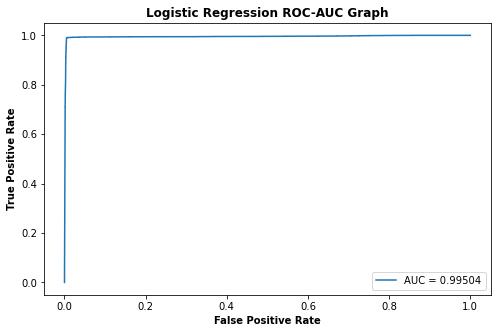

In [45]:
X_test_log = X_test.loc[:,(X_test.dtypes == 'int') | (X_test.dtypes == 'float')]
AUC_ROC_Graph(model=log_reg,model_name='Logistic Regression',data=X_test_log)


Train Set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     60717
           1       0.98      0.98      0.98     23283

    accuracy                           0.99     84000
   macro avg       0.99      0.99      0.99     84000
weighted avg       0.99      0.99      0.99     84000



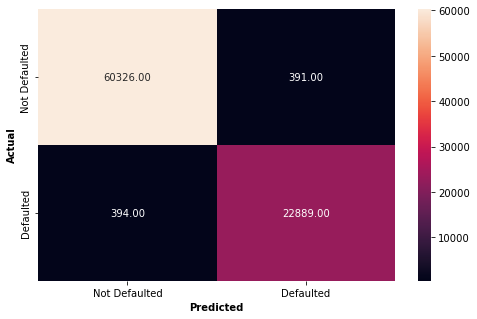




Test Set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15179
           1       0.99      0.98      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



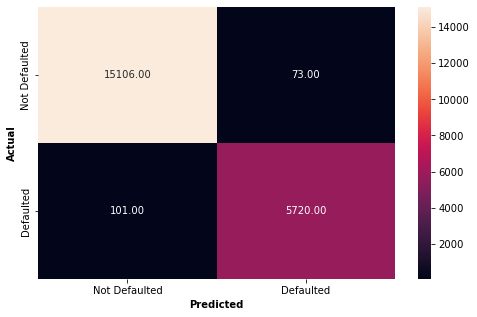

In [46]:
# Checking the performance on the training data
print("Train Set")
y_pred_train_log = log_reg.predict(X_train_log)
metrics_score(y_train, y_pred_train_log)

print("\n\n")

# Metric score for test dataset. 
print("Test Set")
y_pred_test = log_reg.predict(X_test_log)
metrics_score(y_test, y_pred_test)

In [47]:
test.shape

(45000, 16)

In [51]:
print("Hackathon Test Set Submission")

ID = range(105000,149999+1,1)

test_log = test.loc[:,(test.dtypes == 'int') | (test.dtypes == 'float')]
y_pred_test_log = log_reg.predict(test_log)
y_pred_test_log



Hackathon Test Set Submission


array([1, 0, 1, ..., 0, 0, 0])

In [58]:
Model_log = pd.DataFrame({'ID':ID,'Default':y_pred_test_log})
Model_log.to_csv("Model_log.csv", index=False)

### K-Nearest Neighbors (K-NN

In [59]:
# Using Grid Search to find the value of K and other hyperparameters
knn = KNeighborsClassifier()

params_knn = {'n_neighbors':np.arange(2, 20, 1), 'weights':['uniform','distance'], 'p':[1, 2]}

grid_knn = GridSearchCV(estimator = knn, param_grid = params_knn, scoring = 'f1', cv = 10)

model_knn = grid_knn.fit(X_train,y_train)

knn_estimator = model_knn.best_estimator_

print(knn_estimator)

KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')


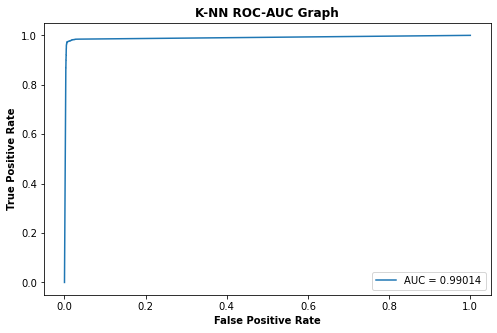

In [60]:
AUC_ROC_Graph(model=knn_estimator,model_name='K-NN',data=X_test)
# AUC: 0.99014

In [164]:
print("Train Set")
y_pred_train_knn = knn_estimator.predict(X_train)
metrics_score(y_train, y_pred_train_knn)

 
print("\n Test Set")
y_pred_test_knn = knn_estimator.predict(X_test)
metrics_score(y_test, y_pred_test_knn)

In [70]:
y_pred_test_knn = knn_estimator.predict(test)
y_pred_test_knn

In [71]:
Model_knn = pd.DataFrame({'ID':ID,'Default':y_pred_test_knn})
Model_knn.to_csv("Model_knn.csv", index=False)

### XBG Classifier


In [157]:
base = xgb.XGBClassifier(eta=0.1,
                      nrounds=1000,
                      max_depth=8,
                      colsample_bytree=0.5,
                      scale_pos_weight=1.1,
                      booster='gbtree',
                      metric='multi:softmax',
                      learning_rate =0.1,
                      n_estimators=140,
                      min_child_weight=1,
                      gamma=0,
                      subsample=0.8,
                      objective= 'binary:logistic',
                      nthread=4,
                      )
xgb1 = base
xgb1.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))

[10:46:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "metric", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0,
              metric='multi:softmax', min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=4,
              nrounds=1000, nthread=4, num_parallel_tree=1, ...)

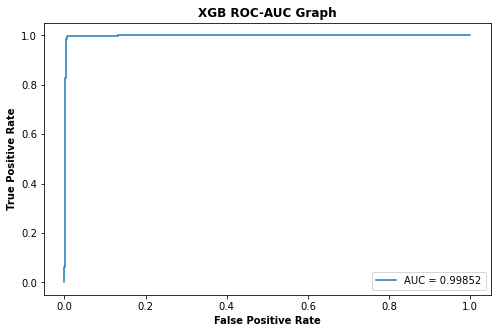

In [78]:
AUC_ROC_Graph(model=xgb1,model_name='XGB',data=X_test)


Train Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60717
           1       0.98      1.00      0.99     23283

    accuracy                           0.99     84000
   macro avg       0.99      1.00      0.99     84000
weighted avg       0.99      0.99      0.99     84000



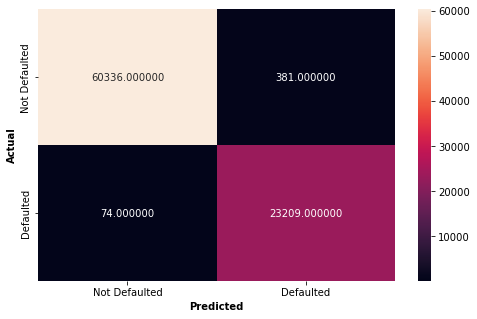

Test Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.99      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



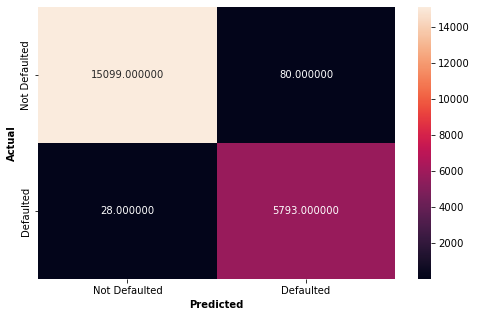

In [121]:
print("Train Set")
y_pred_train_xgb1 = xgb1.predict(X_train)
metrics_score(y_train,y_pred_train_xgb1)

print("Test Set")
y_pred_test_xgb1 = xgb1.predict(X_test)

metrics_score(y_test,y_pred_test_xgb1)

In [92]:
y_pred_test_xgb1 = xgb1.predict(test)
y_pred_test_xgb1


Model_xgb1 = pd.DataFrame({'ID':ID,'Default':y_pred_test_xgb1})
Model_xgb1.to_csv("Model_xgb1.csv", index=False)

### Random Forest Model 1

In [84]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight = {0: 0.20, 1: 0.80}, random_state = 1)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60717
           1       1.00      1.00      1.00     23283

    accuracy                           1.00     84000
   macro avg       1.00      1.00      1.00     84000
weighted avg       1.00      1.00      1.00     84000



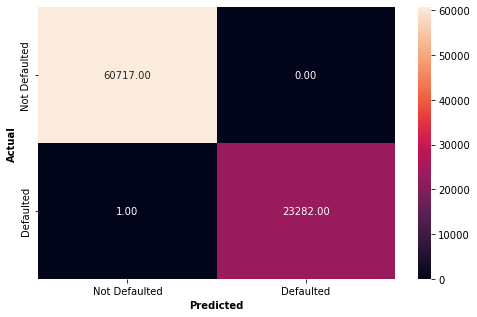

Test Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.99      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



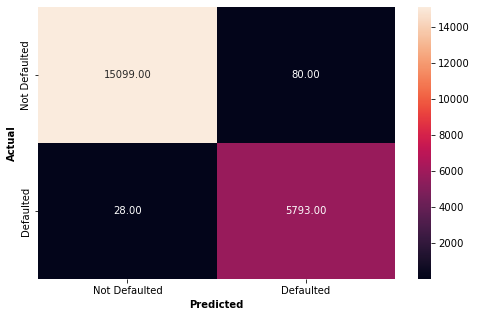

In [85]:
# Checking performance on the training data
print("Train Set")
y_pred_train_rf = rf_estimator.predict(X_train)
metrics_score(y_train, y_pred_train_rf)


# Checking performance on the training data
print("Test Set")
y_pred_test_rf = rf_estimator.predict(X_test)
metrics_score(y_test, y_pred_test_rf)

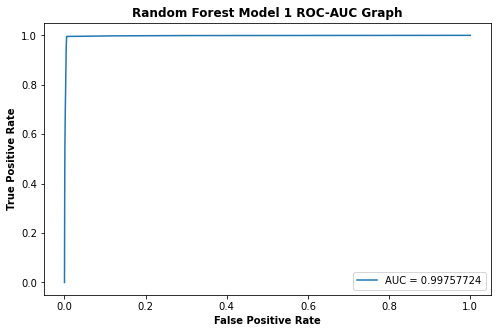

In [174]:
AUC_ROC_Graph(model=rf_estimator,model_name='Random Forest Model 1',data=X_test)


<AxesSubplot:xlabel='Importance'>

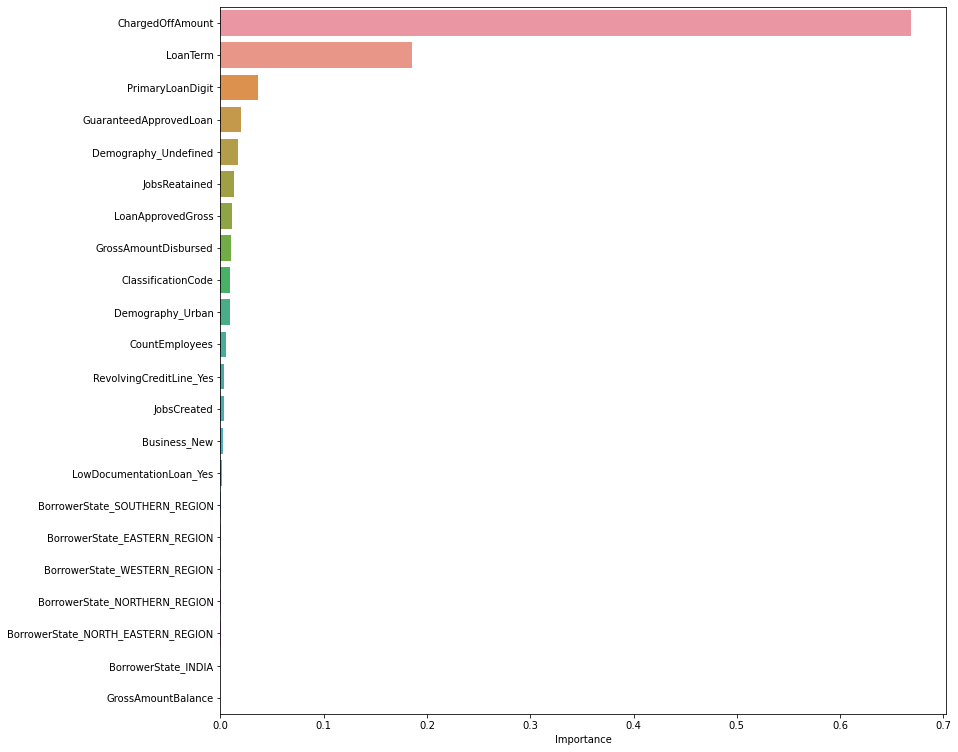

In [140]:
importances = rf_estimator.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)

In [91]:
y_pred_test_rf1 = rf_estimator.predict(test)
y_pred_test_rf1


Model_rf1 = pd.DataFrame({'ID':ID,'Default':y_pred_test_rf1})
Model_rf1.to_csv("Model_rf1.csv", index=False)

Notes: 
    - Using graphics from Random Forest to elminate predictors from training and test set. 

### Constructing new train/test Set

In [208]:
new_predictors =  importance_df.iloc[0:14,].index.values #importance_df.loc[importance_df['Importance']> 1.563040e-03,].index.values
new_predictors
# train[new_predictors]
# Grabbing everything higher than BorrowerState_SOUTHERN_REGION

array(['ChargedOffAmount', 'LoanTerm', 'PrimaryLoanDigit',
       'GuaranteedApprovedLoan', 'Demography_Undefined', 'JobsReatained',
       'LoanApprovedGross', 'GrossAmountDisbursed', 'ClassificationCode',
       'Demography_Urban', 'CountEmployees', 'RevolvingCreditLine_Yes',
       'JobsCreated', 'Business_New'], dtype=object)

In [209]:
X_train_mod2 = X_train[new_predictors]
X_test_mod2 = X_test[new_predictors]
test_mod2 = test[new_predictors]

## XGB Model 2

In [210]:
xgb2 = xgb.XGBClassifier(eta=0.1,
                      nrounds=1500,
                      max_depth=8,
                      colsample_bytree=0.5,
                      scale_pos_weight=1.1,
                      booster='gbtree',
                      metric='multi:softmax',
                      learning_rate =0.1,
                      n_estimators=140,
                      min_child_weight=1,
                      gamma=0,
                      subsample=0.8,
                      objective= 'binary:logistic',
                      nthread=4,
                      )


xgb2.fit(X_train_mod2._get_numeric_data(), np.ravel(y_train, order='C'))

[19:35:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "metric", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0,
              metric='multi:softmax', min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=4,
              nrounds=1500, nthread=4, num_parallel_tree=1, ...)

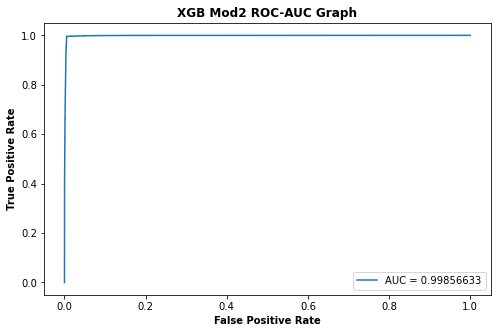

In [211]:
AUC_ROC_Graph(model=xgb2,model_name='XGB Mod2',data=X_test_mod2)


Train Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60717
           1       0.98      1.00      0.99     23283

    accuracy                           0.99     84000
   macro avg       0.99      1.00      0.99     84000
weighted avg       0.99      0.99      0.99     84000



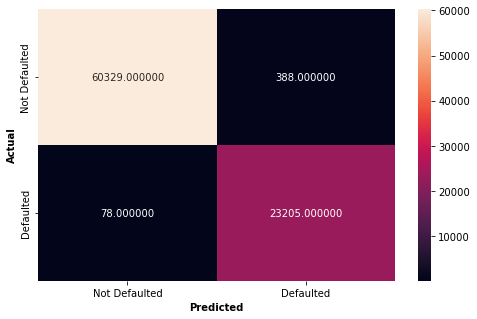

Test Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.99      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



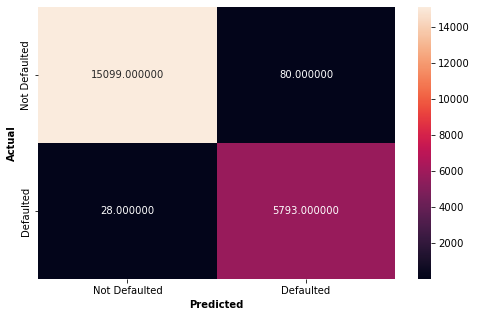

In [185]:
print("Train Set")
y_pred_train_xgb2 = xgb2.predict(X_train_mod2)
metrics_score(y_train,y_pred_train_xgb2)

print("Test Set")
y_pred_test_xgb2 = xgb2.predict(X_test_mod2)

metrics_score(y_test,y_pred_test_xgb2)

In [186]:
y_pred_test_xgb2 = xgb2.predict(test_mod2)
y_pred_test_xgb2


Model_xgb2 = pd.DataFrame({'ID':ID,'Default':y_pred_test_xgb2})
Model_xgb2.to_csv("Model_xgb2.csv", index=False)

## XGB Model 3

In [187]:
# Graid search with XGB 

kfold = KFold(n_splits=10) 

param_test1 = ({'colsample_bytree': [0.75],
  'gamma': [0.0],
  'max_depth': [8],
  'min_child_weight': [5],
  'subsample': [0.75]})

#{
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2),
#  'gamma':[(i/10.0) for i in range(0,5)],
#  'subsample':[(i/100.0) for i in range(75,90,5)],
#  'colsample_bytree':[(i/100.0) for i in range(75,90,5)]
# }

# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}


# Consider changing the n_jobs and cv to 10.

gsearch1 = GridSearchCV(estimator = xgb2, 
                        param_grid = param_test1, 
                        scoring = scoring,
                        n_jobs=10, 
                        refit='AUC',
                        cv=kfold)
gsearch1.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
gsearch1.best_params_, gsearch1.best_score_

[19:25:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "metric", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({'colsample_bytree': 0.75,
  'gamma': 0.0,
  'max_depth': 8,
  'min_child_weight': 5,
  'subsample': 0.75},
 0.9981643735275686)

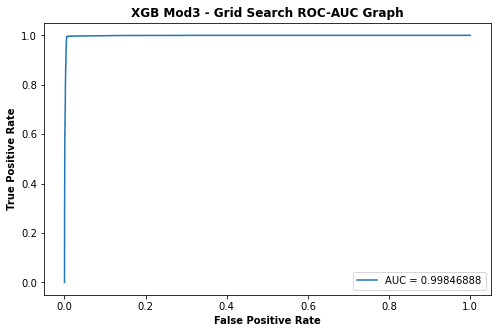

In [188]:
AUC_ROC_Graph(model=gsearch1,model_name='XGB Mod3 - Grid Search',data=X_test)


Train Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     60717
           1       0.98      1.00      0.99     23283

    accuracy                           0.99     84000
   macro avg       0.99      0.99      0.99     84000
weighted avg       0.99      0.99      0.99     84000



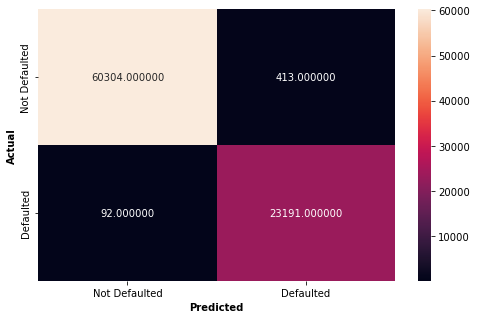

Test Set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15179
           1       0.99      1.00      0.99      5821

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



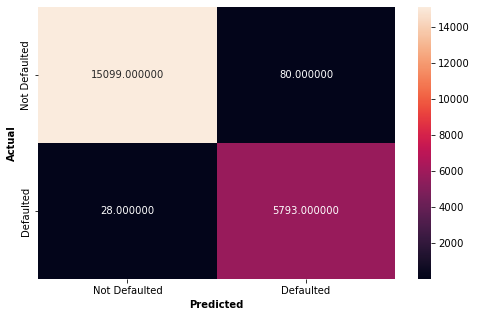

In [190]:
print("Train Set")
y_pred_train_xbg_gs = gsearch1.predict(X_train)
metrics_score(y_train,y_pred_train_xbg_gs)

print("Test Set")
y_pred_test_xgb_gs = gsearch1.predict(X_test)
metrics_score(y_test,y_pred_test_xgb_gs)

In [192]:
y_pred_test_gs1 = gsearch1.predict(test)
y_pred_test_gs1


Model_gs1 = pd.DataFrame({'ID':ID,'Default':y_pred_test_gs1})
Model_gs1.to_csv("Model_gs1.csv", index=False)

### Random Forest Model 2

In [212]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(class_weight = {0: 0.20, 1: 0.80}, random_state = 1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": [1000, 1500],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.5, 0.75, 'auto','log']
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fitting the model
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_features=0.5,
                       min_samples_leaf=2, n_estimators=1000, random_state=1)

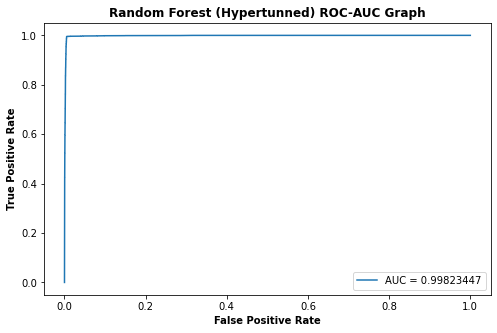

In [214]:
AUC_ROC_Graph(model=rf_estimator_tuned,model_name='Random Forest (Hypertunned)',data=X_test)

In [ ]:
# Checking performance on the training data\
print("Train Set")
y_pred_train_rf_tuned = rf_estimator_tuned.predict(X_train)
metrics_score(y_train, y_pred_train_rf_tuned)
              
              
# Checking performance on the test data
print("Test Set")
y_pred_test_rf_tuned = rf_estimator_tuned.predict(X_test)
metrics_score(y_test, y_pred_test_rf_tuned)

In [ ]:
importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)

In [ ]:
y_pred_test_rf2 = rf_estimator_tuned.predict(test)
y_pred_test_rf2


Model_rf2 = pd.DataFrame({'ID':ID,'Default':y_pred_test_rf2})
Model_rf2.to_csv("Model_rf2.csv", index=False)

In [ ]:
2